In [1]:

# 0. 패키지 임포트
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. 데이터 불러오기
train = pd.read_csv('train.csv', index_col=0) # 코랩 사용 시 경로(/content/drive/My Drive/Colab Notebooks/) 추가
test = pd.read_csv('test.csv', index_col=0)
sample_submission = pd.read_csv('sample_submission.csv', index_col=0)

# 2. Train 데이터의 타입을 Sample_submission에 대응하는 가변수 형태로 변환
column_number = {}
for i, column in enumerate(sample_submission.columns):
    column_number[column] = i
    
def to_number(x, dic):
    return dic[x]

train['type_num'] = train['type'].apply(lambda x : to_number(x, column_number))

# 3.모델에 적용할 데이터 셋 준비 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, StandardScaler, Normalizer

train_x = train.drop(columns=['type', 'type_num'], axis=1)
del train_x['fiberID']
train_y = train['type_num']
test_x = test
del test_x['fiberID']

train_x.describe()

,psfMag_u,psfMag_g,psfMag_r,psfMag_i,psfMag_z,fiberMag_u,fiberMag_g,fiberMag_r,fiberMag_i,fiberMag_z,petroMag_u,petroMag_g,petroMag_r,petroMag_i,petroMag_z,modelMag_u,modelMag_g,modelMag_r,modelMag_i,modelMag_z
count,1.999910e+05,199991.000000,199991.000000,199991.000000,199991.000000,1.999910e+05,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000
mean,-6.750146e+00,18.675373,18.401235,18.043495,17.663526,1.084986e+01,19.072693,19.134483,18.183331,18.000882,21.837903,18.454136,18.481525,17.686617,17.699207,20.110991,18.544375,18.181544,17.692395,17.189281
std,1.187678e+04,155.423024,127.128078,116.622194,123.735298,4.172116e+03,749.256162,90.049058,122.378972,145.862346,789.472333,154.376277,97.240448,145.730872,142.691880,122.299062,161.728183,133.984475,131.183416,133.685138
min,-5.310802e+06,-40022.466071,-27184.795793,-26566.310827,-24878.828280,-1.864766e+06,-215882.917191,-21802.656144,-20208.516262,-26505.602101,-24463.431833,-25958.752324,-23948.588523,-40438.184078,-30070.729379,-26236.578659,-36902.402336,-36439.638493,-38969.416822,-26050.710196
25%,1.965259e+01,18.701180,18.048572,17.747663,17.425523,1.994040e+01,18.902851,18.259352,17.903615,17.606148,19.247795,18.113933,17.479794,17.050294,16.804705,19.266214,18.076120,17.423425,16.977671,16.705774
50%,2.087136e+01,19.904235,19.454492,19.043895,18.611799,2.104910e+01,20.069038,19.631419,19.188763,18.710967,20.366848,19.586559,19.182789,18.693370,18.174592,20.406840,19.547674,19.143156,18.641756,18.100997
75%,2.216043e+01,21.150297,20.515936,20.073528,19.883760,2.233754e+01,21.385830,20.773911,20.331419,20.133179,21.797480,21.004397,20.457491,20.019112,19.807652,21.992898,20.962386,20.408140,19.968846,19.819554
max,1.877392e+04,3538.984910,3048.110913,4835.218639,9823.740407,4.870154e+03,248077.513380,12084.735440,8059.638535,18358.921741,298771.019041,12139.815877,7003.136546,9772.190537,17403.789263,14488.251976,10582.058590,12237.951703,4062.499371,7420.534172


In [2]:
# 간단한 이상치 제거

# 0.985,0.015
x = train_x.copy() 

down_quantiles = x.quantile(0.0009) # 전처리 비율 조정
up_quantiles = x.quantile(0.9991)

outliers_low = (x < down_quantiles)
outliers_high = (x > up_quantiles)

x[outliers_low] = np.nan
x.fillna(down_quantiles, inplace=True)

x[outliers_high] = np.nan
x.fillna(up_quantiles, inplace=True)

# 0.99, 0.01
x2 = train_x.copy() 

down_quantiles2 = x.quantile(0.02)
up_quantiles2 = x.quantile(0.98)

outliers_low2 = (x < down_quantiles2)
outliers_high2 = (x > up_quantiles2)

x2[outliers_low2] = np.nan
x2.fillna(down_quantiles2, inplace=True)

x2[outliers_high2] = np.nan
x2.fillna(up_quantiles2, inplace=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f877035b978>,
      dtype=object)

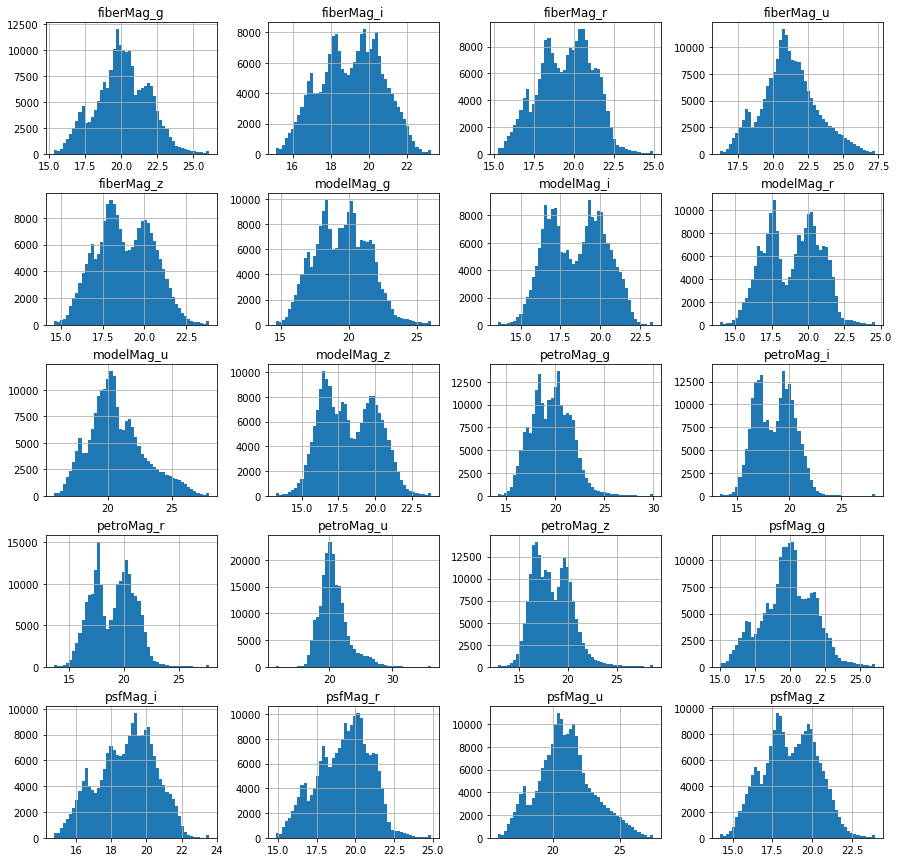

In [3]:
x.hist(bins=50, figsize=(15, 15))

In [4]:
x = x.values
train_y = train_y.values

x_train, x_val, y_train, y_val = train_test_split(x, train_y, train_size=0.9)

# 3-1 다중 분류 시 One-hot Encoding
from sklearn.preprocessing import OneHotEncoder
onehot_encoder = OneHotEncoder()
y_train = y_train.reshape(len(y_train), -1) 
y_val = y_val.reshape(len(y_val), -1)
y_train = onehot_encoder.fit_transform(y_train)
y_val = onehot_encoder.fit_transform(y_val)

print(x_train.shape)
print(y_train.shape)

(179991, 20)
(179991, 19)


/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in versio

In [6]:
# gelu activation function -  Gaussian Error Linear Units (GELUs)
# https://arxiv.org/abs/1606.08415
from keras.layers import Activation
from keras.utils.generic_utils import get_custom_objects
import tensorflow as tf

class Gelu(Activation):
    def __init__(self, activation, **kwargs):
        super(Gelu, self).__init__(activation, **kwargs)
        self.__name__='gelu'
        
def gelu(x):
    return 0.5 * x * (1 + tf.tanh(tf.sqrt(2 / np.pi) * (x + 0.044715 * tf.pow(x, 3))))

get_custom_objects().update({'gelu': Gelu(gelu)})

ModuleNotFoundError: No module named 'keras'

In [ ]:
# StandardScaler
scaler = StandardScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_val_scaled = scaler.transform(x_val)

# 4. 모델 생성하기
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout, LeakyReLU
from keras import regularizers

model = Sequential()

model.add(Dense(128, input_shape=(20,)))
model.add(BatchNormalization())
model.add(Activation(gelu))
model.add(Dropout(0.25))
model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation(gelu))
model.add(Dropout(0.25))
model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation(gelu))
model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation(gelu))
model.add(Dropout(0.25))
model.add(Dense(19, activation='softmax'))


# 5. 모델 훈련시키기 
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=300, mode='min')
model.compile(loss='categorical_crossentropy', 
              optimizer='adam',
              metrics=['acc'])
hist = model.fit(x_train_scaled,y_train, epochs=2000, batch_size=256, validation_data = [x_val_scaled, y_val], callbacks=[early_stopping])

# # 6. 평가 검증하기
loss, acc = model.evaluate(x_val_scaled, y_val)
print('loss :', loss)
print('acc :', acc)

# 7. 예측
test_x_scaled = scaler.transform(test_x)
y_pred = model.predict(test_x_scaled)


# 8. 제출 파일 생성
submission = pd.DataFrame(data=y_pred, columns=sample_submission.columns, index=sample_submission.index)
submission.to_csv('submission(9).csv', index=True)


# early stopping patience 200 이상일 경우 overfitting
# Dropout 0.3 이하 overfitting 발생
# hidden layer 4개 이하 overfitting 발생
# node = 512일 경우 overfitting 발생

# 가장 기록 좋았을 때
# model = Sequential()

# model.add(Dense(128, input_shape=(20,)))
# model.add(LeakyReLU(alpha=0.07))
# model.add(BatchNormalization())
# model.add(Dense(256))
# model.add(LeakyReLU(alpha=0.07))
# model.add(BatchNormalization())
# model.add(Dropout(0.45))
# model.add(Dense(256))
# model.add(LeakyReLU(alpha=0.07))
# model.add(BatchNormalization())
# model.add(Dropout(0.45))
# model.add(Dense(256))
# model.add(LeakyReLU(alpha=0.07))
# model.add(Dropout(0.45))
# model.add(Dense(256))
# model.add(LeakyReLU(alpha=0.07))
# model.add(Dropout(0.45))
# model.add(Dense(19, activation='softmax'))

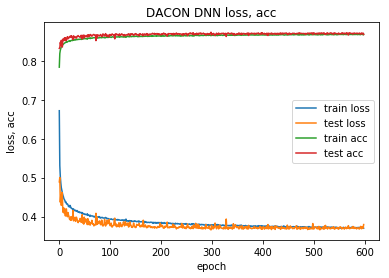

In [20]:
# matplotlib으로 보기
import matplotlib.pyplot as plt

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('DACON DNN loss, acc')
plt.xlabel('epoch')
plt.ylabel('loss, acc')
plt.legend(['train loss', 'test loss', 'train acc', 'test acc'])
plt.show()

# First
# loss : 0.3751423681736819
# acc : 0.8720957365285246

# Second
# loss : 0.37057404349997003
# acc : 0.8689456582069397

# Third
# loss : 0.36412223417814554
# acc : 0.8720468282699585

# 최소 0.35~0.33까지 떨어뜨려야 함
# 참고 epoch 30% = earlystopping